In [1]:
import pandas as pd
from langchain_core.documents import Document as LangchainDocument
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores.utils import DistanceStrategy
from sentence_transformers import SentenceTransformer
from transformers import (
    AutoTokenizer,
)

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import List, Optional
import pickle
import time

In [2]:
test_data= pd.read_json("../qa/wikipedia-dev.json")

In [3]:
print(f"Test set size: {len(test_data)}")

Test set size: 7993


In [4]:
#Build a list of docs from the downloaded Wikipedia documents
def getDocs(examples):
    # List of docs
    docs = []
    # Extracting metadata and filenames from the examples (training data)
    for example in examples["Data"]:
        filename = example["EntityPages"][0]["Filename"]
        with open(f"..//evidence/wikipedia/{filename}", "r") as file:
            context_text = file.read()
        # Create a Document for RAG
        newDoc = LangchainDocument(
                metadata={
                    'question_id': example['QuestionId'],
                    'source': example['EntityPages'][0]['DocSource'],
                    'answer_type': example['Answer']['Type'],
                    'entity_name': example['Answer'].get('NormalizedValue', ''), # Default to empty string if missing
                    'aliases': example['Answer'].get('Aliases', []), # Default to empty list if missing
                    'normalized_value': example['Answer'].get('NormalizedValue', ''), # Default to empty string if missing
                    'filename': example['EntityPages'][0]['Filename'],
                },
                page_content=context_text
        )
        docs.append(newDoc)
    return docs

In [5]:
RAW_KNOWLEDGE_BASE = getDocs(test_data)

In [7]:
EMBEDDING_MODEL_NAME = "thenlper/gte-small"
def split_documents(chunk_size: int, knowledge_base: List[LangchainDocument], tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    TRIVIAQA_SEPARATORS = [
        "\n\n", "\n", ". ", "? ", "! ", "; ", ": ", ", ", " ", ""
    ]

    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer,
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=TRIVIAQA_SEPARATORS,
    )

    docs_processed = []
    for doc in tqdm(knowledge_base, desc="Splitting documents"):
        chunks = text_splitter.split_documents([doc])
        docs_processed.extend(chunks)

    unique_texts = {}
    docs_processed_unique = []
    for doc in tqdm(docs_processed, desc="Removing duplicates"):
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


In [8]:
# Use 250 token chunk size
docs_processed = split_documents(250, RAW_KNOWLEDGE_BASE, tokenizer_name=EMBEDDING_MODEL_NAME)

# Save the processed chunks
with open("test_data_saved/test_docs_processed_250.pkl", "wb") as file:
    pickle.dump(docs_processed, file)

Splitting documents:   0%|          | 0/7993 [00:00<?, ?it/s]

Removing duplicates:   0%|          | 0/289182 [00:00<?, ?it/s]

  0%|          | 0/184879 [00:00<?, ?it/s]

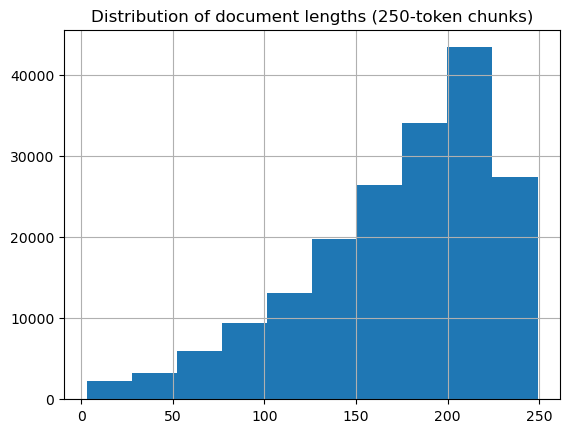

In [9]:
# Plot the chunk length distribution
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
pd.Series(lengths).hist()
plt.title("Distribution of document lengths (250-token chunks)")
plt.show()

In [10]:
# Build and save FAISS index
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)

In [11]:
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE)
KNOWLEDGE_VECTOR_DATABASE.save_local("test_data_saved/Faiss_250")

In [12]:
user_query = "Which Lloyd Webber musical premiered in the US on 10th December 1993?"
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top 1 document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)
print(
    "\n==================================Top 2 document=================================="
)
print(retrieved_docs[1].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[1].metadata)


Starting retrieval for user_query='Which Lloyd Webber musical premiered in the US on 10th December 1993?'...

==================================Top 1 document==================================
Andrew Lloyd Webber, Baron Lloyd-Webber   (born 22 March 1948) is an English composer and impresario of musical theatre. 

Several of his musicals have run for more than a decade both in the West End and on Broadway. He has composed 13 musicals, a song cycle, a set of variations, two film scores, and a Latin Requiem Mass. Several of his songs have been widely recorded and were hits outside of their parent musicals, notably "The Music of the Night" from The Phantom of the Opera, "I Don't Know How to Love Him" from Jesus Christ Superstar, "Don't Cry for Me, Argentina" and "You Must Love Me" from Evita, "Any Dream Will Do" from Joseph and the Amazing Technicolor Dreamcoat and "Memory" from Cats.
==================================Metadata==================================
{'question_id': 'tc_33', 's